# inicialização

In [85]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *
import plotly.express as px
from scipy.interpolate import interp1d


def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))), 'MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))

def recursiveMQ(y, phi, pad):
    size = phi.shape[1]
    nit = y.shape[0]
    p = 1000 * np.eye(size)
    teta = np.zeros((size, 1))

    erro = np.zeros(nit)
    print(phi.shape, nit)

    for t in range(0, nit):
        fi = phi[t,:]
        fi = fi.reshape(-1, 1)
        #print(teta, fi.T,'\n')
        erro[t] = y[t] - np.dot(teta.T, fi)
        k = np.dot(np.dot(p, fi), 1 / (1 + np.dot(np.dot(fi.T, p), fi)))
        teta = teta + np.dot(k, erro[t])
        p = p - np.dot(np.dot(k, fi.T), p)

    return np.squeeze(teta)

def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r

ballbeam  = np.loadtxt('data/ballbeam.dat')
print(ballbeam.shape)
part = 300#ballbeam.shape[0] // 2#700

u = ballbeam[:part, 0].reshape((1,-1))
y = ballbeam[:part, 1].reshape((1,-1))

wn = 0.15
b1, a1 = signal.butter(4, wn, 'low')

'''y += 0.005
u += 0.002'''
filtered = signal.filtfilt(b1, a1, y, padlen=100)

dy = np.zeros(filtered.shape)
dy[:, 1:] = (filtered[0, 1:] - filtered[0, :-1]) / 0.1

t = np.arange(0, part/10, 0.1)

fig=px.line(x=t, y=y[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=filtered[0].T ,mode='lines')
fig.show()

wn = 0.2
b1, a1 = signal.butter(4, wn, 'low')
ufiltered = signal.filtfilt(b1, a1, u, padlen=100)
#ufiltered[0, :15] = 0
U = integrate(ufiltered.T).T

fig=px.line(x=t, y=u[0].T, height=400, width=1300)
fig.add_scatter(x=t, y=ufiltered[0].T, mode='lines')
#fig.add_scatter(x=t, y=U[0].T, mode='lines')
fig.show()


(1000, 2)


In [123]:
#filtered[0, :20] = -0.003
#ufiltered[0, :16] = 0

n_amostras = t.shape[0] * 10
#x_novo = np.linspace(t[0], t[-1], n_amostras)
x_novo = np.arange(0, 29.9, 0.01)

# Interpolação linear
interpolacao_linear = interp1d(t, dy, kind='quadratic')
y_novo = interpolacao_linear(x_novo)

interpolacao_linear = interp1d(t, ufiltered, kind='quadratic')
u_novo = interpolacao_linear(x_novo)

y_novo[0, :145] = y_novo[0, 145]
fig=px.line(x=x_novo, y=y_novo[0].T, height=400, width=1300)
fig.add_scatter(x=x_novo, y=u_novo[0].T * 10, mode='lines')
#fig.add_scatter(x=t, y=u[0].T * 10, mode='lines')
fig.show()

# Estimação

In [202]:
ui = u_novo.copy()
yi = np.zeros((2, y_novo.shape[1]))
dt = 0.01
yi[0, 1:] = (y_novo[0][1:] - y_novo[0][:-1]) / dt
yi[0, :170] = 0
#ui[0, :160] = 0
'''yi[0, 4000:] = 0
ui[0, 4000:] = 0'''
yi[1] = y_novo

output = 0  # 0 ou 1

num = [8]
params = []
params.append({'nb':[2, 3],'na':[5], 'level':3, 'nonlinear':[0,0,0,0,0, 0, 0], 'root':False, 'delay':2, 'diff':False})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)
#print(ss)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

#print(len(ss), vCandidatos.shape)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-15)

model = ss[selected]
print(model, selected)

theta = LSM(yi[output, pad:], psi)
#theta1 = recursiveMQ(yi[output, pad:], psi, pad)

model = ss[selected]
pprint(model)
print(model @ theta)


slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)

print("\nSimulação livre")
metrics(yi, slivre)
print("\nUm passo a frente")
metrics(yi, yhat)
#yi[0, 1:] = (y_novo[0][1:] - y_novo[0][:-1]) / dt

fig=px.line(x=x_novo, y=yi[0].T, height=400, width=1300)
fig.add_scatter(x=x_novo, y=slivre, mode='lines')
fig.show()

[Y1.1 Y2.3 Y2.1 Y2.2 U1.4] [1, 5, 3, 4, 7]
[Y1.1 Y2.3 Y2.1 Y2.2 U1.4]
0.00512614189254879*U1.4 + 0.940059047431809*Y1.1 + 104.984223934876*Y2.1 - 204.116927603531*Y2.2 + 99.1328089396992*Y2.3
Simulação livre
0 [1]
-------- [Y1.1, Y1.2, Y2.1, Y2.2, Y2.3, U1.1, U1.2, U1.3, U1.4, U1.5]

Simulação livre
RMSE: 0.029125897994916283 MSE: 0.0008483179340102682 
AET: 97.84479698401529 
MAPE: 4866658155.78755%

Um passo a frente
RMSE: 0.02913499936344259 MSE: 0.0008488481879078001 
AET: 97.44647747665942 
MAPE: 4866658161.89498%


### view

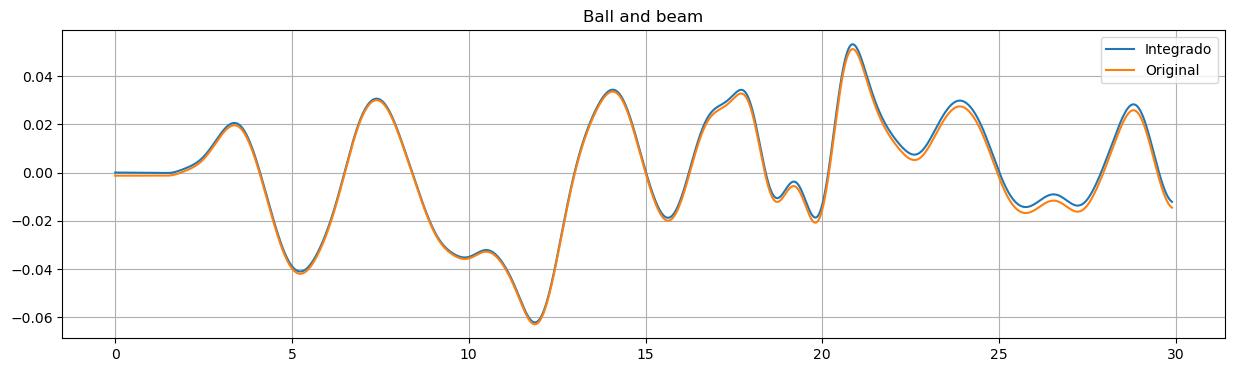

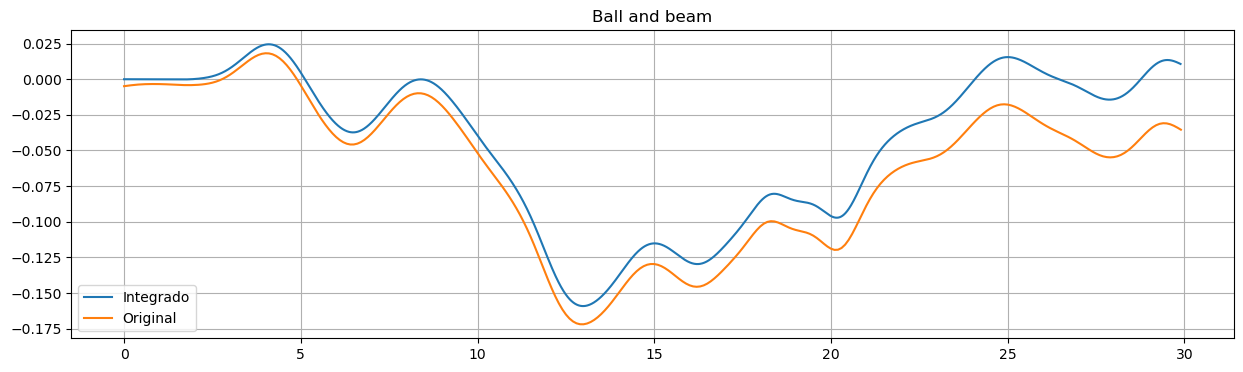

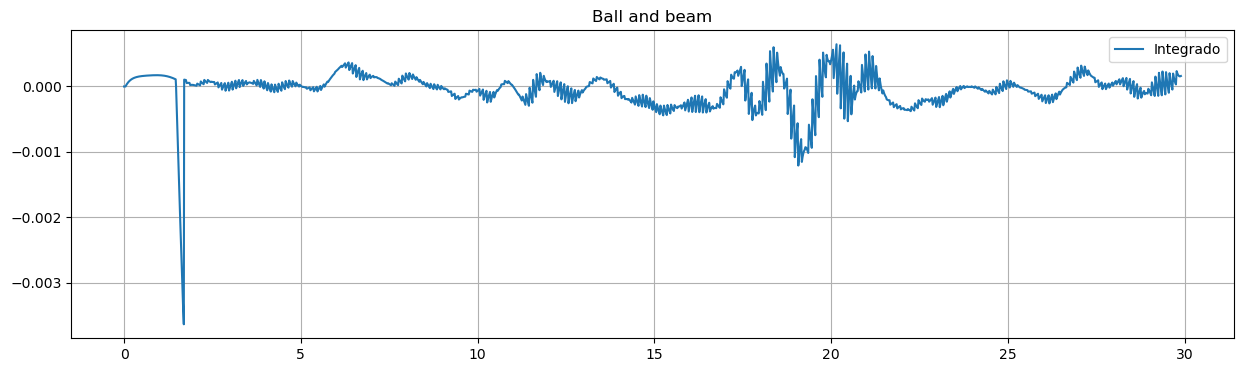

In [203]:
s = slivre.copy()

w = integrate(s, 0.01)
plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(x_novo, w.T, label='Integrado')
plt.plot(x_novo, y_novo[0], label='Original')
plt.legend()
plt.grid()
plt.show()

ww = integrate(w, 0.01)
plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(x_novo, ww.T, label='Integrado')
plt.plot(t, filtered[0], label='Original')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,4))
plt.title("Ball and beam")
plt.plot(x_novo, (yi[0] - s), label='Integrado')
plt.legend()
plt.grid()
plt.show()

# Validação

### preparação

In [216]:
part2 = 600

uVal = ballbeam[:part2, 0].reshape((1,-1))
yVal = ballbeam[:part2, 1].reshape((1,-1))

wn = 0.15
b1, a1 = signal.butter(4, wn, 'low')
filtered = signal.filtfilt(b1, a1, yVal, padlen=100)

dy = np.zeros(filtered.shape)
dy[:, 1:] = (filtered[0, 1:] - filtered[0, :-1]) / 0.1


t = np.arange(0, part2/10, 0.1)

wn = 0.2
b1, a1 = signal.butter(4, wn, 'low')
ufiltered = signal.filtfilt(b1, a1, uVal, padlen=100)

n_amostras = t.shape[0] * 10
t_val = np.arange(0, 59.9, 0.01)

interpolacao_linear = interp1d(t, dy, kind='quadratic')
y_val = interpolacao_linear(t_val)

interpolacao_linear = interp1d(t, ufiltered, kind='quadratic')
u_val = interpolacao_linear(t_val)

y_novo[0, :145] = y_novo[0, 145]
fig=px.line(x=t_val, y=y_val[0].T, height=400, width=1300)
fig.add_scatter(x=t_val, y=u_val[0].T * 10, mode='lines')
fig.show()


In [214]:
print(t_val.shape, dy.shape)

(5990,) (1, 600)


### simulação

Simulação livre
0 [1]
-------- [Y1.1, Y1.2, Y2.1, Y2.2, Y2.3, U1.1, U1.2, U1.3, U1.4, U1.5]
Modelo selecionado:
0.00512614189254879⋅U1.4 + 0.940059047431809⋅Y1.1 + 104.984223934876⋅Y2.1 - 20
4.116927603531⋅Y2.2 + 99.1328089396992⋅Y2.3

Simulação livre
RMSE: 0.03701391205595093 MSE: 0.0013700296856856695 
AET: 249.60354149826014 
MAPE: 11.52062%

Um passo a frente
RMSE: 0.03705044128650821 MSE: 0.0013727351995249922 
AET: 248.97251898782037 
MAPE: 12.07535%


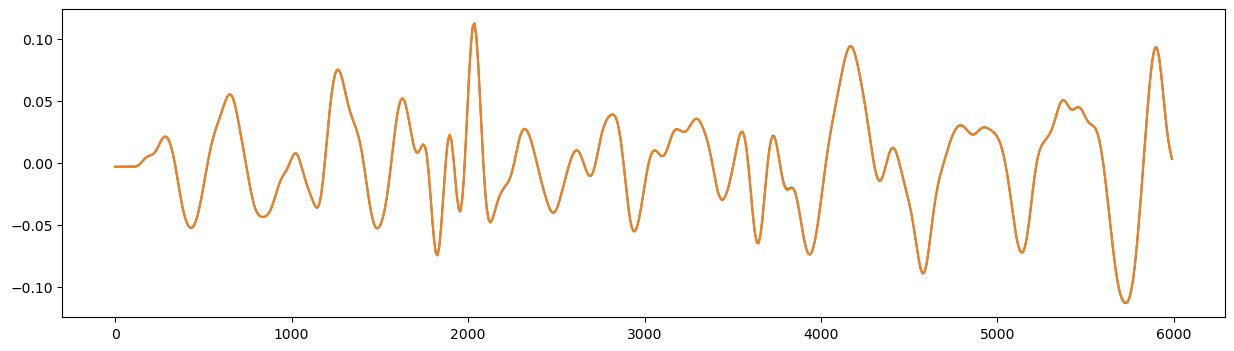

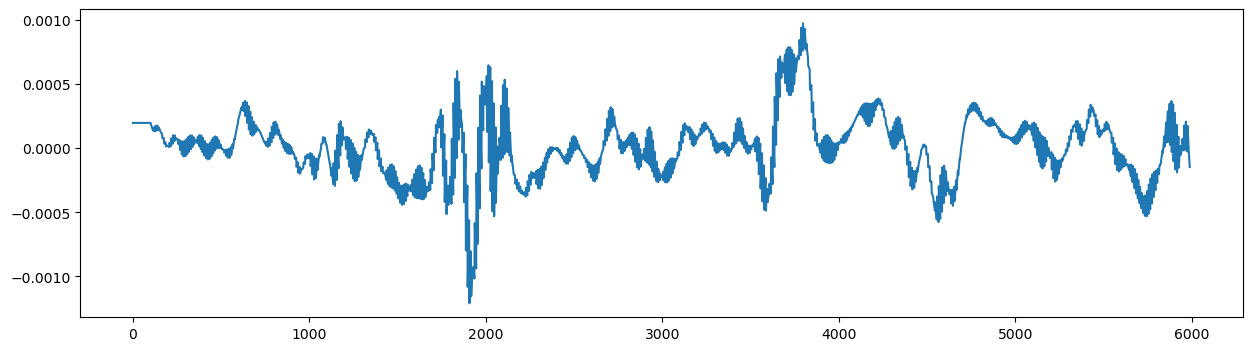

In [238]:

yval = np.zeros((2, y_val.shape[1]))
dt = 0.01
yval[0, 1:] = (y_val[0][1:] - y_val[0][:-1]) / dt
yval[0, :100] = yval[0, 100]
yval[1] = y_val

valLivre = sselector.predict(u_val, yval, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u_val, yval, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

valLivre[:100] = valLivre[100]
print("\nSimulação livre")
metrics(yval, valLivre)
print("\nUm passo a frente")
metrics(yval, yhat)

plt.figure(figsize=(15,4))
plt.plot(yval[0].T)
plt.plot(valLivre.T)
plt.show()

plt.figure(figsize=(15,4))
plt.plot((yval[0] - valLivre).T)
plt.show()
